In [1]:
import tensorflow as tf

print(tf.__version__)

2.2.0


# Load the dataset

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base = '../input/face-expression-recognition-dataset/images/'

train_dir = os.path.join(base, 'train')
valid_dir = os.path.join(base, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    batch_size=64,
    class_mode='categorical'
)

valid_dataset = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(48,48),
    batch_size=64,
#     color_mode='grayscale',
    class_mode='categorical'
)

input_shape = (48,48,3)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Function for training 
We often train the data with different model, so it is better to define a function which can define how the training works and the feedback that we expect in a single function

In [3]:
import matplotlib.pyplot as plt

def train(model, train_dataset, valid_dataset, epoch=15):
    history = model.fit_generator(
              train_dataset,
              epochs=epoch,
              validation_data=valid_dataset
    )

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Model 1 : Baseline Model

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # 7 output neuron for 7 classes
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer='RMSProp',
    loss='categorical_crossentropy',
    metrics = ['acc']
)

model.summary()

In [ ]:
train(model, train_dataset, valid_dataset)

In [ ]:
model.save('basic_cnn.h5')

## Model 2: Baseline Model with drop out

In [ ]:
cnn_do = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    # 7 output neuron for 7 classes
    tf.keras.layers.Dense(7, activation='softmax')
])

opt = tf.keras.optimizers.RMSprop(lr=1e-4)

cnn_do.compile(
    optimizer='RMSProp',
    loss='categorical_crossentropy',
    metrics = ['acc']
)

cnn_do.summary()

In [ ]:
train(cnn_do, train_dataset, valid_dataset, 50)
cnn_do.save('cnn_do.h5')

## Model 3 : Augmented Dataset

In [ ]:
train_data_aug = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=(-0.5, 0.5),
    height_shift_range=(-0.5, 0.5),
    fill_mode="nearest",
    
)

train_dataset_aug = train_data_aug.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

In [ ]:
train(cnn_do, train_dataset_aug, valid_dataset)
cnn_do.save('cnn_do_aug.h5')

## Model 4 : Pretrained model (Resnet)

In [ ]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet.summary()

In [ ]:
resnet.trainable = False

resnet = tf.keras.models.Sequential([
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')
])

resnet.compile(
    optimizer='RMSProp',
    loss='categorical_crossentropy',
    metrics = ['acc']
)

resnet.summary()

In [ ]:
train(resnet, train_dataset, valid_dataset)

## Model 5 : HingeCategoricalLoss

In [ ]:
cnn_do = cnn_do

cnn_do.compile(
    optimizer='RMSProp',
    loss=tf.keras.losses.CategoricalHinge(),
    metrics = ['acc']
)

cnn_do.summary()

In [ ]:
train(cnn_do, train_dataset, valid_dataset)

## Model 6: Batch Normalization

In [4]:
cnn_bn = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    # 7 output neuron for 7 classes
    tf.keras.layers.Dense(7, activation='softmax')
])


opt = tf.keras.optimizers.RMSprop(lr=1e-4)

cnn_bn.compile(
    optimizer=opt,
    loss=tf.keras.losses.CategoricalHinge(),
    metrics=['acc']
)

cnn_bn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0

Epoch 1/50
451/451 [==============================] - 83s 183ms/step - loss: 1.2124 - acc: 0.2780 - val_loss: 1.1876 - val_acc: 0.3129
Epoch 2/50
451/451 [==============================] - 64s 142ms/step - loss: 1.1438 - acc: 0.3446 - val_loss: 1.0641 - val_acc: 0.3831
Epoch 3/50
451/451 [==============================] - 64s 142ms/step - loss: 1.1114 - acc: 0.3693 - val_loss: 1.0759 - val_acc: 0.3895
Epoch 4/50
451/451 [==============================] - 64s 141ms/step - loss: 1.0826 - acc: 0.3867 - val_loss: 1.0459 - val_acc: 0.4087
Epoch 5/50
451/451 [==============================] - 64s 142ms/step - loss: 1.0566 - acc: 0.4019 - val_loss: 1.0213 - val_acc: 0.4233
Epoch 6/50
451/451 [==============================] - 64s 143ms/step - loss: 1.0367 - acc: 0.4172 - val_loss: 1.0234 - val_acc: 0.4226
Epoch 7/50
451/451 [==============================] - 65s 145ms/step - loss: 1.0243 - acc: 0.4233 - val_loss: 1.0061 - val_acc: 0.4297
Epoch 8/50
451/451 [==============================] - 6

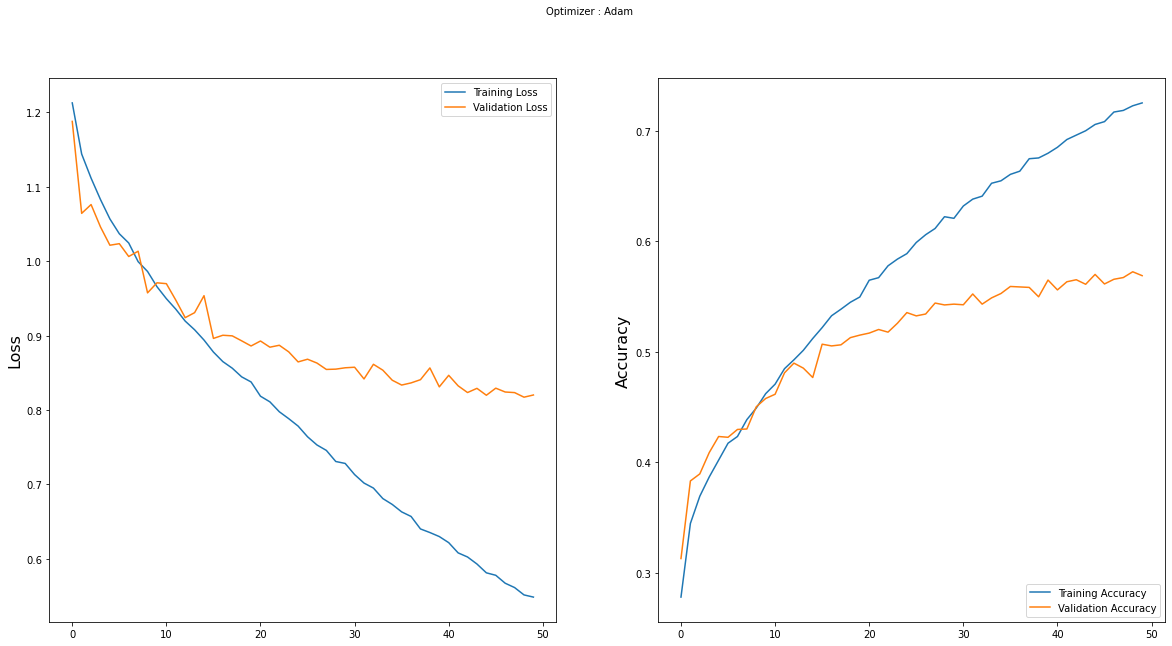

In [5]:
train(cnn_bn, train_dataset, valid_dataset, 50)
cnn_bn.save("cnn_bn.pt")

In [7]:
cnn_bn.save('model.h5')

## Model 7 : CNN with batch normalization and drop out

In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Inference Function for Deployment:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.image import resize
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

class Inference():
    
    labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
    def __init__(self, modelpath):
        try:
            self.model = load_model(modelpath)
        except:
            print("Model not Found")

        self.inp_shape = self.model.input.shape.as_list()

    def predict(self, image):
        image = self.preprocess(image)
        pred = self.model.predict(image)
        pred = np.argmax(pred)
        return self.labels[pred]

    def preprocess(self, image):
        image = resize(image, (self.inp_shape[1], self.inp_shape[2]))
        image = rgb_to_grayscale(image)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        return image
    
inference = Inference('./cnn_do.h5')

In [ ]:
from keras.preprocessing.image import load_img

test_image = '../input/face-expression-recognition-dataset/images/train/surprise/10007.jpg'
img = load_img(test_image)
img = tf.keras.preprocessing.image.img_to_array(img)
inference.predict(img)

In [ ]:
dummy_image = np.random.random((50,50,3))
inference = Inference('./cnn_do.h5')
print(inference.predict(dummy_image))